In [1]:
import numpy as np
import os
import time
import ica

from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter
from functools import partial

import numpy as np
import multiprocessing as mp
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append('/data/users2/yxiao11/model/satellite_project')
from moduler_gen import *

In [8]:
import numpy as np
import trimesh
import random

# def make_satellite_with_ids(color_list, color_to_material):
#     # Sample colors
#     def sample_color(i, j):
#         return color_list[np.random.randint(i, j)][:3] + [255]

#     color1_up = sample_color(0, 15)
#     color1_mid = sample_color(15, 30)
#     color1_down = sample_color(30, 45)
#     color2 = sample_color(45, 60)  # antenna
#     color3 = sample_color(60, 65)  # connector
#     color4 = sample_color(65, len(color_list))  # panel

#     components = []

#     h_total = random.uniform(2.0, 4.0)
#     h_third = h_total / 3.0

#     def apply_random_rotation(mesh):
#         angles = np.radians(np.random.uniform(-30, 30, 3))
#         rot_x = trimesh.transformations.rotation_matrix(angles[0], [1, 0, 0])
#         rot_y = trimesh.transformations.rotation_matrix(angles[1], [0, 1, 0])
#         rot_z = trimesh.transformations.rotation_matrix(angles[2], [0, 0, 1])
#         mesh.apply_transform(rot_x @ rot_y @ rot_z)

#     # Down part
#     down_radius = random.uniform(0.6, 1.0)
#     body_down = trimesh.creation.cylinder(radius=down_radius, height=h_third)
#     body_down.apply_translation([0, 0, -h_total / 2 + h_third / 2])
#     apply_random_rotation(body_down)
#     body_down.visual.vertex_colors = np.tile(color1_down, (len(body_down.vertices), 1))
#     components.append((body_down, color_to_material[tuple(color1_down[:3])]))

#     # Mid part
#     mid_shape = random.choice(['cylinder', 'box', 'cone', 'capsule', 'ellipsoid'])
#     if mid_shape == 'cylinder':
#         body_mid = trimesh.creation.cylinder(radius=random.uniform(0.6, 1.0), height=h_third)
#     elif mid_shape == 'box':
#         size = np.random.uniform(1.0, 1.6, 3)
#         body_mid = trimesh.creation.box(extents=size)
#     elif mid_shape == 'cone':
#         body_mid = trimesh.creation.cone(radius=random.uniform(0.6, 1.0), height=h_third)
#     elif mid_shape == 'capsule':
#         body_mid = trimesh.creation.capsule(radius=random.uniform(0.5, 0.7), height=h_third)
#     elif mid_shape == 'ellipsoid':
#         sphere = trimesh.creation.icosphere(subdivisions=2, radius=1.0)
#         scale = np.eye(4)
#         scale[0, 0] = random.uniform(0.8, 1.2)
#         scale[1, 1] = random.uniform(0.8, 1.2)
#         scale[2, 2] = h_third
#         sphere.apply_transform(scale)
#         body_mid = sphere
#     apply_random_rotation(body_mid)
#     body_mid.visual.vertex_colors = np.tile(color1_mid, (len(body_mid.vertices), 1))
#     components.append((body_mid, color_to_material[tuple(color1_mid[:3])]))

#     # Up part
#     up_shape = random.choice(['cylinder', 'sphere', 'cone', 'torus', 'box'])
#     if up_shape == 'cylinder':
#         body_up = trimesh.creation.cylinder(radius=random.uniform(0.6, 1.0), height=h_third)
#     elif up_shape == 'sphere':
#         body_up = trimesh.creation.icosphere(radius=random.uniform(0.6, 1.0))
#     elif up_shape == 'cone':
#         body_up = trimesh.creation.cone(radius=random.uniform(0.6, 1.0), height=h_third)
#     elif up_shape == 'torus':
#         body_up = trimesh.creation.torus(random.uniform(0.5, 0.8), random.uniform(0.1, 0.2))
#     elif up_shape == 'box':
#         size = np.random.uniform(0.8, 1.4, 3)
#         body_up = trimesh.creation.box(extents=size)
#     body_up.apply_translation([0, 0, h_total / 2 - h_third / 2])
#     apply_random_rotation(body_up)
#     body_up.visual.vertex_colors = np.tile(color1_up, (len(body_up.vertices), 1))
#     components.append((body_up, color_to_material[tuple(color1_up[:3])]))

#     # Antenna
#     antenna_shape = random.choice(['icosphere', 'cylinder', 'cone', 'torus'])
#     if antenna_shape == 'icosphere':
#         antenna = trimesh.creation.icosphere(radius=random.uniform(0.3, 0.5))
#     elif antenna_shape == 'cylinder':
#         antenna = trimesh.creation.cylinder(radius=0.2, height=random.uniform(0.8, 1.2))
#     elif antenna_shape == 'cone':
#         antenna = trimesh.creation.cone(radius=0.3, height=random.uniform(0.6, 1.0))
#     elif antenna_shape == 'torus':
#         antenna = trimesh.creation.torus(random.uniform(0.2, 0.4), random.uniform(0.05, 0.15))
#     antenna.apply_translation([0, 0, h_total / 2 + 1.0])
#     apply_random_rotation(antenna)
#     antenna.visual.vertex_colors = np.tile(color2, (len(antenna.vertices), 1))
#     components.append((antenna, color_to_material[tuple(color2[:3])]))

#     # Connectors
#     connector_style = random.choice(['box', 'cylinder'])
#     conn_length = random.uniform(1.5, 2.0)
#     if connector_style == 'box':
#         connector1 = trimesh.creation.box(extents=[conn_length, 0.5, 0.5])
#         connector2 = trimesh.creation.box(extents=[conn_length, 0.5, 0.5])
#     else:
#         connector1 = trimesh.creation.cylinder(radius=0.15, height=conn_length)
# #         connector1.apply_transform(trimesh.transformations.rotation_matrix(np.pi / 2, [0, 1, 0]))
#         connector2 = connector1.copy()
#     connector1.apply_translation([conn_length / 2 + 1.0, 0, 0])
#     connector2.apply_translation([-conn_length / 2 - 1.0, 0, 0])
# #     apply_random_rotation(connector1)
# #     apply_random_rotation(connector2)
#     connectors = trimesh.util.concatenate([connector1, connector2])
#     connectors.visual.vertex_colors = np.tile(color3, (len(connectors.vertices), 1))
#     components.append((connectors, color_to_material[tuple(color3[:3])]))

#     # Panels
#     panel_style = random.choice(['standard', 'thin', 'angled'])
#     if panel_style == 'standard':
#         panel1 = trimesh.creation.box(extents=[4.0, 0.01, 2.0])
#         panel2 = trimesh.creation.box(extents=[4.0, 0.01, 2.0])
#     elif panel_style == 'thin':
#         panel1 = trimesh.creation.box(extents=[3.0, 0.01, 1.0])
#         panel2 = trimesh.creation.box(extents=[3.0, 0.01, 1.0])
#     elif panel_style == 'angled':
#         panel1 = trimesh.creation.box(extents=[4.0, 0.01, 2.0])
#         panel2 = trimesh.creation.box(extents=[4.0, 0.01, 2.0])
#         rot1 = trimesh.transformations.rotation_matrix(np.radians(random.uniform(10, 30)), [0, 1, 0])
#         rot2 = trimesh.transformations.rotation_matrix(np.radians(random.uniform(-30, -10)), [0, 1, 0])
#         panel1.apply_transform(rot1)
#         panel2.apply_transform(rot2)
#     panel1.apply_translation([random.uniform(4.0, 5.0), 0, 0])
#     panel2.apply_translation([random.uniform(-5.0, -4.0), 0, 0])
#     apply_random_rotation(panel1)
#     apply_random_rotation(panel2)
#     solar_panels = trimesh.util.concatenate([panel1, panel2])
#     solar_panels.visual.vertex_colors = np.tile(color4, (len(solar_panels.vertices), 1))
#     components.append((solar_panels, color_to_material[tuple(color4[:3])]))

#     satellite = trimesh.util.concatenate([
#         body_down, body_mid, body_up,
#         antenna, connectors, solar_panels
#     ])

#     return satellite, components



def make_satellite_with_ids(color_list, color_to_material):
    color1_up = color_list[np.random.randint(0, 15)]
    color1_mid = color_list[np.random.randint(15, 30)]
    color1_down = color_list[np.random.randint(30, 45)]
    color2 = color_list[np.random.randint(45, 60)]  # antenna
    color3 = color_list[np.random.randint(60, 65)]  # connector
    color4 = color_list[np.random.randint(65, len(color_list))]  # panel
    # color1_up = color_list[0]
    # color1_mid = color_list[1]
    # color1_down = color_list[2]
    # color2 = color_list[3]  # antenna
    # color3 = color_list[4]  # connector
    # color4 = color_list[5]  # panel

    color1_up = color1_up[:3] + [255]
    color1_mid = color1_mid[:3] + [255]
    color1_down = color1_down[:3] + [255]
    color2 = color2[:3] + [255]
    color4 = color4[:3] + [255]

    components = []

    # Body split into up, mid, down
    h_total = 3.0
    h_third = h_total / 3.0

    # Down part
    body_down = trimesh.creation.cylinder(radius=0.8, height=h_third, sections=20)
    body_down.apply_translation([0, 0, -h_total / 2 + h_third / 2])
    body_down.visual.vertex_colors = np.tile(color1_down, (len(body_down.vertices), 1))
    components.append((body_down, color_to_material[tuple(color1_down[:3])]))

    # Mid part
    body_mid = trimesh.creation.cylinder(radius=0.8, height=h_third, sections=50)
    body_mid.visual.vertex_colors = np.tile(color1_mid, (len(body_mid.vertices), 1))
    components.append((body_mid, color_to_material[tuple(color1_mid[:3])]))

    # Up part
    body_up = trimesh.creation.cylinder(radius=0.8, height=h_third, sections=20)
    body_up.apply_translation([0, 0, h_total / 2 - h_third / 2])
    body_up.visual.vertex_colors = np.tile(color1_up, (len(body_up.vertices), 1))
    components.append((body_up, color_to_material[tuple(color1_up[:3])]))

    # Antenna
    antenna = trimesh.creation.icosphere(subdivisions=2, radius=0.4)
    antenna.apply_translation([0, 0, h_total / 2 + 0.8])
    antenna.visual.vertex_colors = np.tile(color2, (len(antenna.vertices), 1))
    components.append((antenna, color_to_material[tuple(color2[:3])]))

    # Connectors
    connector1 = trimesh.creation.box(extents=[1.0, 0.3, 0.3])
    connector1.apply_translation([1.0 + 0.5, 0, 0])
    connector2 = trimesh.creation.box(extents=[1.0, 0.3, 0.3])
    connector2.apply_translation([-1.0 - 0.5, 0, 0])
    connectors = trimesh.util.concatenate([connector1, connector2])
    connectors.visual.vertex_colors = np.tile(color3, (len(connectors.vertices), 1))
    components.append((connectors, color_to_material[tuple(color3[:3])]))

    # Panels
    panel1 = trimesh.creation.box(extents=[4.0, 0.01, 2.0])
    panel1.apply_translation([4.5, 0, 0])
    panel2 = trimesh.creation.box(extents=[4.0, 0.01, 2.0])
    panel2.apply_translation([-4.5, 0, 0])
    solar_panels = trimesh.util.concatenate([panel1, panel2])
    solar_panels.visual.vertex_colors = np.tile(color4, (len(solar_panels.vertices), 1))
    components.append((solar_panels, color_to_material[tuple(color4[:3])]))

    # Combine all
    satellite = trimesh.util.concatenate([
        body_down, body_mid, body_up,
        antenna, connectors, solar_panels
    ])

    return satellite, components

In [9]:
def compute_sigma_pixels(wavelength_nm, D_m=3.6, pixel_um=5, focal_length_m=100):
    wavelength_m = wavelength_nm * 1e-9
    theta_rad = 0.25 * wavelength_m / D_m
    theta_arcsec = theta_rad * 206265

    plate_scale = (206265 * pixel_um) / (focal_length_m * 1e6)
    sigma_pixels = theta_arcsec / plate_scale
    return sigma_pixels

In [10]:
def generate_sample(fake_spectra, image_size=256, camera_pos=[0,0,25]):
    
    
    
    # fake_spectra = generate_fake_spectra(data_type=data_type,
    #                                      material_path = material_path,
    #                                      num_spec=num_spec)
    
    color_list, color_to_material = generate_distinct_color_list(len(fake_spectra))
    
    _, components = make_satellite_with_ids(color_list, color_to_material)
    
#     angles = np.random.randint(0, 360, 3)
    angles = np.array([90., 0., 0.])
#     angles = np.array([0., 0., 0.])
#     angles[0] = np.random.randint(-90,90,1)
#     angles[1] = np.random.randint(-90,90,1)
    angles[2] = np.random.randint(-90,90,1)

    material_mask = rasterize_components_with_depth(
        components, image_size=image_size, camera_pos=camera_pos, angles=angles)
    
    spectral_cube, labels = create_spectral_cube((image_size, image_size), material_mask, fake_spectra)
    
    zoomed_material_mask = rasterize_components_with_depth(
        components, image_size=100, camera_pos=[0,0,20], angles=angles)
    
    zoomed_spectral_cube, _ = create_spectral_cube((100, 100), zoomed_material_mask, fake_spectra)

    return material_mask,spectral_cube, labels, zoomed_spectral_cube

def simulator(image_size, fake_spectra, camera_pos=[0,0,25]):
    
    material_mask,spectral_cube, labels, zoomed_spectral_cube = generate_sample(
        fake_spectra,
        # material_path = '/data/users2/yxiao11/model/satellite_project/material_spectral',
        image_size=image_size, 
        # data_type=data_type, 
        # num_spec=num_spec, 
        camera_pos=camera_pos
    )
    #######################
#     # Generate random k and b for each sample
#     k = np.random.uniform(0.7, 1.2)  # Example range for k
#     b = np.random.uniform(1, 3)      # Example range for b
    n_slices = spectral_cube.shape[0]
#     # Compute kernel sizes based on the linear formula
#     kernel_sizes = (k * np.arange(5,n_slices+5)/1 + b).astype(int)
#     kernel_sizes[kernel_sizes % 2 == 0] += 1  # Ensure odd kernel sizes
#     #######################
#     # Convert kernel sizes to corresponding sigmas
#     sigmas = kernel_sizes / 2.5  # Adjust this scaling factor as needed   

    sigmas = np.linspace(3.5e-7,2.5e-6,n_slices)
    sigmas = 0.25*sigmas/(3.6*5e-6)*200
#     sigmas = [compute_sigma_pixels(s) for s in np.linspace(800,1500,n_slices)]
    blurred_cube = np.stack(
        [gaussian_filter(spectral_cube[j], 
                                       sigma=sigmas[j], 
                                       mode="mirror") for j in range(n_slices)], 
        axis=0
    ) 
    return material_mask,spectral_cube, blurred_cube, labels, zoomed_spectral_cube



In [11]:
# for i in range(num_spec):
#     plt.plot(fake_spectra[i])

In [12]:
data_type = 'Pristine'
num_spec = 100
fake_spectra = generate_fake_spectra(data_type=data_type,
            material_path='/data/users2/yxiao11/model/satellite_project/material_spectral/',
            num_spec=num_spec)

# Original list of keys (sorted numerically)
ids = sorted(fake_spectra.keys())

# Spectra matrix: shape (71, num_bands)
spectra_matrix = np.stack([fake_spectra[i] for i in ids], axis=0)

# Correlation matrix + sorting
corr_matrix = np.abs(np.corrcoef(spectra_matrix))
corr_strength = corr_matrix.sum(axis=1)
sorted_indices = np.argsort(-corr_strength)  # Descending

# Reorder original keys by correlation dominance
sorted_keys = [ids[i] for i in sorted_indices]
sorted_fake_spectra = {new_idx+1: fake_spectra[old_key] for new_idx, old_key in enumerate(sorted_keys)}

fake_spectra = sorted_fake_spectra

[ 1 23 35 56 62 69]


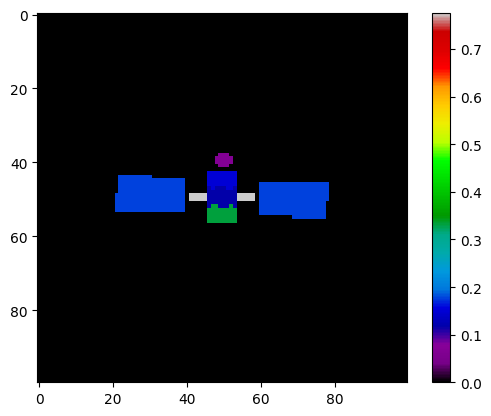

In [17]:
image_size = 50
material_mask, spectral_cube, blurred_cube, labels, zoomed_spectral_cube = simulator(image_size, fake_spectra, camera_pos=[0,0,50])
print(labels+1)
blurred_cube += np.random.randn(*blurred_cube.shape)*0.02

# blurred_cube = blurred_cube[3:33]
# spectral_cube = spectral_cube[3:33]

real_labels = labels+1
plt.imshow(zoomed_spectral_cube[5], cmap='nipy_spectral')
plt.colorbar()

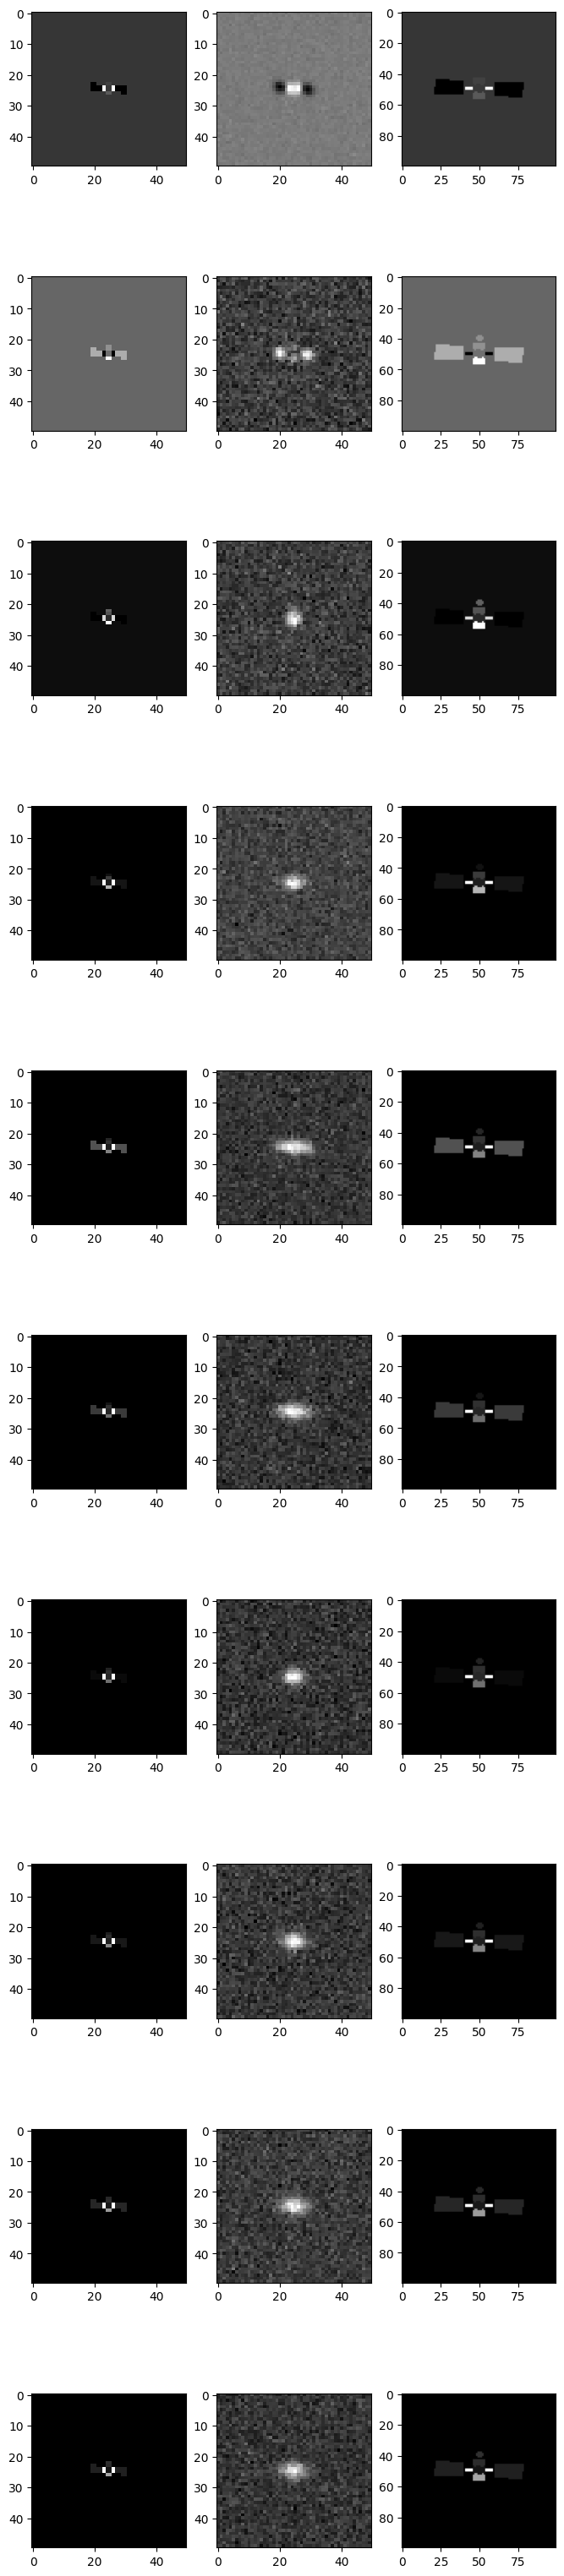

In [18]:
# row = pca_remain
row = np.arange(0,10)
fig,ax = plt.subplots(len(row),3, figsize=(8,4*len(row)))
for i,idx in enumerate(row):
    ax[i,0].imshow(spectral_cube[idx], 'gray')
    ax[i,1].imshow(blurred_cube[idx], 'gray')
#     ax[idx,2].imshow(blurred_cube[idx][48:72,48:72], 'gray')
    ax[i,2].imshow(zoomed_spectral_cube[idx], 'gray')
#     ax[idx,1].imshow(x[-idx-1], 'gray')

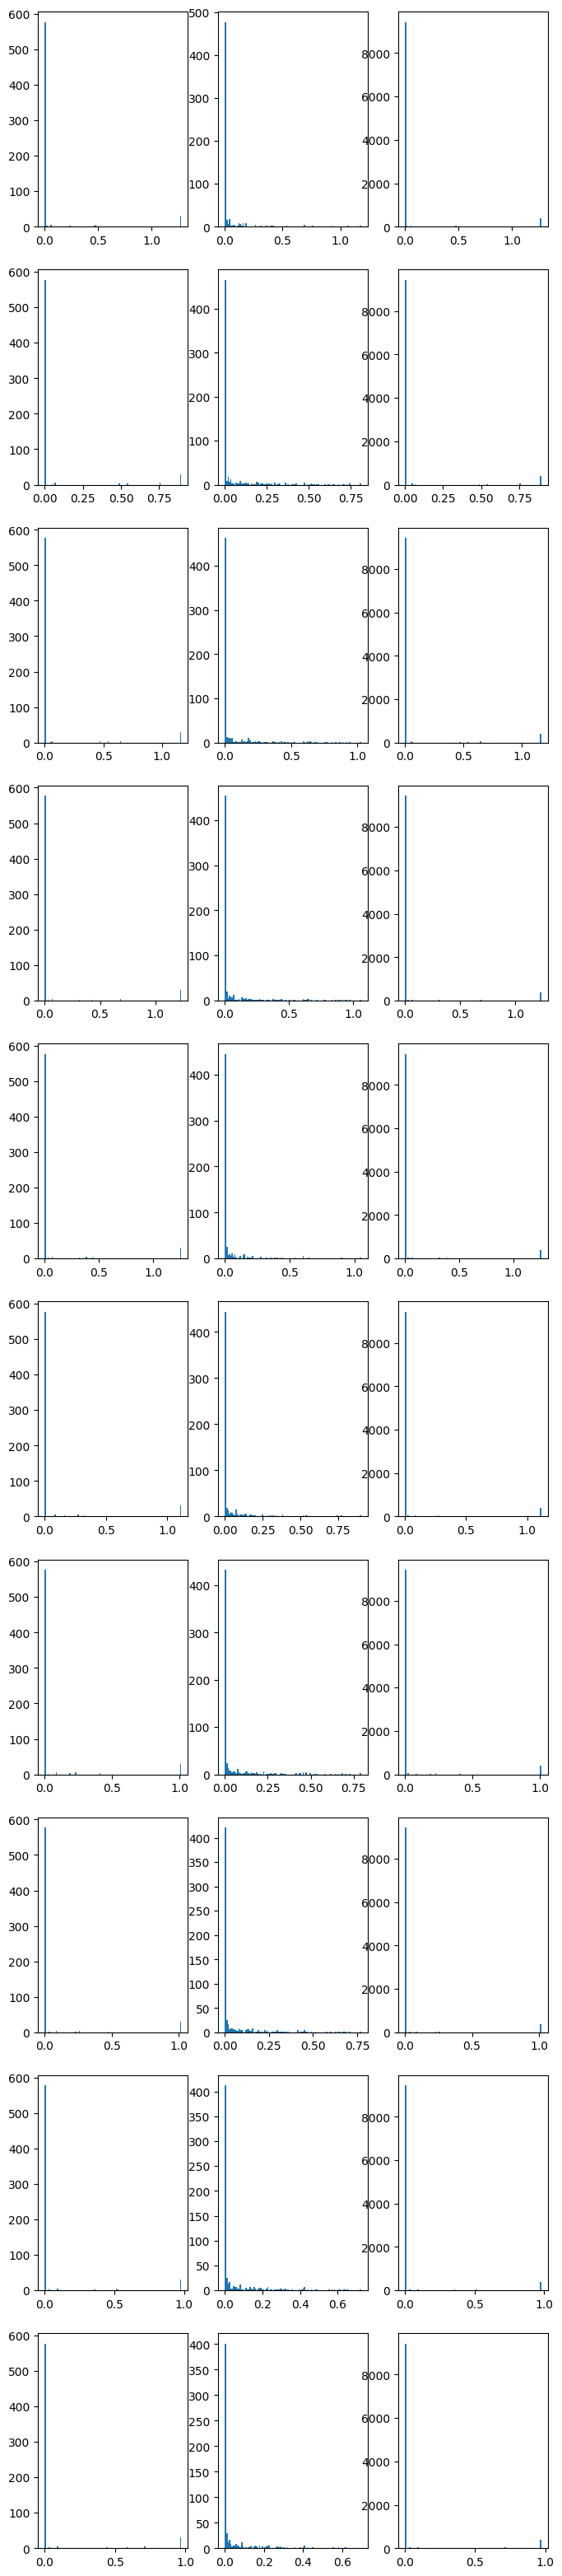

In [157]:
# row = pca_remain
row = 10
fig,ax = plt.subplots(row,3, figsize=(8,4*row))
for idx in range(row):
    ax[idx,0].hist(spectral_cube[idx].flatten(), 100)
    ax[idx,1].hist(blurred_cube[idx].flatten(), 100)
#     ax[idx,2].imshow(blurred_cube[idx][48:72,48:72], 'gray')
    ax[idx,2].hist(zoomed_spectral_cube[idx].flatten(), 100)
#     ax[idx,1].imshow(x[-idx-1], 'gray')

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from piq import ssim  # pip install piq
import os
from time import time
import time


def safe_load_numpy(file_path, retries=100, wait=0.1):
    for attempt in range(retries):
        try:
            data = np.load(file_path)   # Attempt to load
            return data                 # Success! Immediately returns
        except (FileNotFoundError, OSError, ValueError) as e:
            if attempt < retries - 1:   # Not the last attempt? Wait, then try again
                time.sleep(wait)
            else:                       # Last attempt and still fails
                raise e

class get_dataset(Dataset):
    def __init__(self, data_dir,):
        self.data_dir = data_dir

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        ipt = safe_load_numpy(self.data_dir[idx])
       
        images_np = ipt[:, None, :, :].astype(np.float32)
        images = torch.tensor(images_np)

        return images[0:1], images[1:]
    
def build_branch():
    return nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 8, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 1, 3, padding=1),
        nn.Sigmoid()
    )
    
    

# data_type = 'mixed'
data_type = 'Pristine'
# data_type = 'Irradiated'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_dir = '/data/users2/yxiao11/model/satellite_project/database/' +data_type + '/blur_cube/'
data_file = []
while len(os.listdir(blur_dir))<1000:
    print('insuffient data:', len(os.listdir(blur_dir)))
    time.sleep(5)

for i in range(len(os.listdir(blur_dir))):
    data_file.append(blur_dir + f"{i}.npy")

my_dataset = get_dataset(data_file)
branches = nn.ModuleList([build_branch() for _ in range(29)]).to(device)
optimizer = optim.Adam([p for net in branches for p in net.parameters()], lr=1e-3)

num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    count = 0
    for ref_image, input_images in my_dataset:
        ref_image, input_images = ref_image.to(device), input_images.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = [branches[i](input_images[i:i+1]) for i in range(29)]  # each: [1, 1, 25, 25]

        # SSIM loss with clamping
        loss = sum(
            1 - ssim(
                torch.clamp(output, 0.0, 1.0),
                torch.clamp(ref_image, 0.0, 1.0),
                data_range=1.0
            )
            for output in outputs
        ) / len(outputs)

        loss.backward()
        optimizer.step()
        total_loss += loss
        count+=1
        if (count + 1) % 100 == 0:
            print(f"count {count}, Avg SSIM-structural loss: {loss.item():.6f}")
    print('------------------------')
    print(f"Epoch {epoch+1}, Avg SSIM-structural loss: {total_loss/1000}")



KeyboardInterrupt: 

In [ ]:

# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# import numpy as np

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# X = np.arange(ref_image.squeeze().cpu().detach().numpy().shape[1])
# Y = np.arange(ref_image.squeeze().cpu().detach().numpy().shape[0])
# X, Y = np.meshgrid(X, Y)
# Z = ref_image.squeeze().cpu().detach().numpy()

# ax.plot_surface(X, Y, Z, cmap='viridis')
# ax.set_title('3D Intensity Surface')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Intensity')
# plt.tight_layout()
# plt.show()

In [ ]:
images_np = blurred_cube[:,None,:,:].astype(np.float32)
images = torch.tensor(images_np).to("cuda" if torch.cuda.is_available() else "cpu")

ref_image = images[0:1]  # [1, 1, 25, 25], g1
input_images = images[1:]  # [19, 1, 25, 25], g2~g20

In [ ]:
# # Visualize output of branch[0] after training
# slices_id = 15

# model_output = branches[slices_id](input_images[slices_id:slices_id+1]).squeeze().cpu().detach().numpy()
# ref_vis = ref_image.squeeze().cpu().numpy()

# plt.subplot(1, 3, 1)
# plt.imshow(ref_vis, cmap='gray')
# plt.title("Reference (g1)")

# plt.subplot(1, 3, 2)
# plt.imshow(model_output, cmap='gray')
# plt.title("Recovered from g2")

# plt.subplot(1, 3, 3)
# plt.imshow(input_images[slices_id:slices_id+1].squeeze().cpu().detach().numpy(), cmap='gray')
# plt.title("g2")

# plt.show()


In [ ]:
recovered_cube = [ref_image.clone().cpu().squeeze().detach().numpy()[None,:,:]]
for i in range(19):
    recovered_cube.append(branches[i](input_images[i:i+1]).squeeze().cpu().detach().numpy()[None,:,:])
    
recovered_cube = np.concatenate(recovered_cube)

In [ ]:
import matplotlib.pyplot as plt

# 假设这三个数组都是 [20, H, W] 的 numpy 数组
# spectral_cube: 原图
# blurred_cube: 模糊图
# recovered_cube: 恢复图

plt.figure(figsize=(5, 36))  # 3列 × 20行

for i in range(20):
    # 原图
    plt.subplot(20, 3, i * 3 + 1)
    plt.imshow(spectral_cube[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Original {i+1}')

    # 模糊图
    plt.subplot(20, 3, i * 3 + 2)
    plt.imshow(blurred_cube[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Blurred {i+1}')

    # 恢复图
    plt.subplot(20, 3, i * 3 + 3)
    plt.imshow(recovered_cube[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Recovered {i+1}')

plt.tight_layout()
plt.show()


In [ ]:
blurred_cube.shape

In [ ]:
# count = 0
# plt.figure(figsize=(10,10))
# for i in range(10):
#     for j in range(10):
#         plt.subplot(10,10,count+1)
        
#         plt.imshow(blurred_cube[count], cmap='gray')
#         count+=1
# #         plt.title('Input')

In [ ]:
# count = 0
# plt.figure(figsize=(10,10))
# for i in range(4):
#     for j in range(5):
#         plt.subplot(4,5,count+1)
        
#         plt.imshow(spectral_cube[count], cmap='gray')
#         count+=1
# #         plt.title('Input')

In [ ]:
# count = 0
# plt.figure(figsize=(10,10))
# for i in range(4):
#     for j in range(5):
#         plt.subplot(4,5,count+1)
        
#         plt.imshow(blurred_cube[count], cmap='gray')
#         count+=1
# #         plt.title('Input')

IndexError: index 100 is out of bounds for axis 0 with size 100

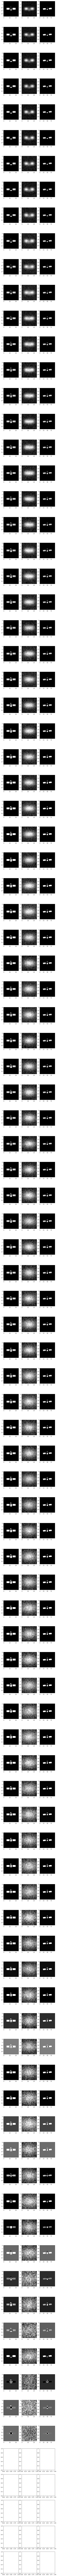

In [13]:
# row = pca_remain
row = 100
fig,ax = plt.subplots(row,3, figsize=(8,4*row))
for idx in range(row):
    ax[idx,0].imshow(spectral_cube[idx+5], 'gray')
    ax[idx,1].imshow(blurred_cube[idx+5], 'gray')
#     ax[idx,2].imshow(blurred_cube[idx][48:72,48:72], 'gray')
    ax[idx,2].imshow(zoomed_spectral_cube[idx+5], 'gray')
#     ax[idx,1].imshow(x[-idx-1], 'gray')

In [ ]:
# nb = blurred_cube.reshape(num_spec,-1).T
# x,_,_ = ica.pca_whiten(nb, 50)
# for i,s in enumerate(x[30:]):
#     plt.plot(s, label=f'{i}')
# plt.legend()

In [ ]:
# plt.imshow(np.cov(spectral_cube[0:num_spec].reshape(num_spec,-1).T))

In [ ]:
# one_material = []
# for x in range(image_size):
#     for y in range(image_size):
#         if material_mask[x, y]==real_labels[2]:
#             one_material.append(blurred_cube[:,x,y][None

# plt.imshow(np.corrcoef(np.concatenate(one_material,0)))

In [ ]:
# ###############

plt.figure(figsize=(30, 30))

# Track used labels to prevent duplicates in legend
used_labels = set()

# Map: label_value → (color, label_text, linestyle or marker)
# Map: label_value → (color, label_text, linestyle or marker)
label_info = {}
for label in labels:
    if 0 <= label < 15:
            label_info[label+1] = ('green', 'body_up', 'o')
    if 15 <= label < 30:
        label_info[label+1] = ('black', 'body_mid', '^')
    if 30 <= label < 45:
        label_info[label+1] = ('blue', 'body_down', 'x')
    if 45 <= label < 60:
        label_info[label+1] = ('pink', 'antenna', 's')
    if 60 <= label < 65:
        label_info[label+1] = ('red', 'connector', '+')
    if 65 <= label :
        label_info[label+1] = ('yellow', 'panel', '*')

for x in range(image_size):
    for y in range(image_size):
        label_value = material_mask[x, y]
        if label_value in label_info:
            color, label, marker = label_info[label_value]
#             y_values = blurred_cube[:, x, y][0:100]
            y_values = recovered_cube[:, x, y]
            # First plot for this label: include legend
            if label not in used_labels:
                plt.plot(y_values, color=color, marker=marker, markevery=10, label=label, linewidth=1)
                used_labels.add(label)
            else:
                plt.plot(y_values, color=color, marker=marker, markevery=10, linewidth=1)

plt.xlabel("Spectral Band")
plt.ylabel("Intensity")
plt.title("Spectral Signatures by Material (with Markers)")
plt.legend(fontsize=30)
plt.grid(True)
plt.show()


In [ ]:
# ###############

plt.figure(figsize=(30, 30))

# Track used labels to prevent duplicates in legend
used_labels = set()

# Map: label_value → (color, label_text, linestyle or marker)
# Map: label_value → (color, label_text, linestyle or marker)
label_info = {}
for label in labels:
    if 0 <= label < 15:
            label_info[label+1] = ('green', 'body_up', 'o')
    if 15 <= label < 30:
        label_info[label+1] = ('black', 'body_mid', '^')
    if 30 <= label < 45:
        label_info[label+1] = ('blue', 'body_down', 'x')
    if 45 <= label < 60:
        label_info[label+1] = ('pink', 'antenna', 's')
    if 60 <= label < 65:
        label_info[label+1] = ('red', 'connector', '+')
    if 65 <= label :
        label_info[label+1] = ('yellow', 'panel', '*')

for x in range(image_size):
    for y in range(image_size):
        label_value = material_mask[x, y]
        if label_value in label_info:
            color, label, marker = label_info[label_value]
#             y_values = blurred_cube[:, x, y][0:100]
            y_values = spectral_cube[:, x, y]
            # First plot for this label: include legend
            if label not in used_labels:
                plt.plot(y_values, color=color, marker=marker, markevery=10, label=label, linewidth=1)
                used_labels.add(label)
            else:
                plt.plot(y_values, color=color, marker=marker, markevery=10, linewidth=1)

plt.xlabel("Spectral Band")
plt.ylabel("Intensity")
plt.title("Spectral Signatures by Material (with Markers)")
plt.legend(fontsize=30)
plt.grid(True)
plt.show()


In [ ]:
# image_size = 32
# pca_remain = 10
# spectral_cube, blurred_cube, labels = simulator(image_size, fake_spectra)
# x,_,_ = ica.pca_whiten(blurred_cube.reshape(num_spec,-1), pca_remain)
# print(labels)
# plt.imshow(x[0].reshape(image_size,image_size))

In [ ]:
# x=x.reshape(pca_remain,image_size,image_size)

In [ ]:
# x,y = np.where(material_mask==71)
# print(x)
# print(y)

In [ ]:
# row = pca_remain
row = 20
fig,ax = plt.subplots(row,3, figsize=(8,4*row))
for idx in range(row):
    ax[idx,0].imshow(spectral_cube[idx], 'gray')
    ax[idx,1].imshow(blurred_cube[idx], 'gray')
    ax[idx,2].imshow(blurred_cube[idx][50:75,50:75], 'gray')
#     ax[idx,1].imshow(x[-idx-1], 'gray')

In [ ]:
for i in range(10):
    material_mask, spectral_cube, blurred_cube, labels = simulator(image_size, fake_spectra)
    print(labels+1)
#     real_labels = labels+1
    # Track used labels to prevent duplicates in legend
    used_labels = set()

    # Map: label_value → (color, label_text, linestyle or marker)
    label_info = {}
    for label in labels:
#         if 0 <= label < 45:
#             label_info[label+1] = ('green', 'body', 'o')
        if 45 <= label < 55:
            label_info[label+1] = ('black', 'antenna', '^')
        if 55 <= label < 65:
            label_info[label+1] = ('blue', 'connector', 'x')
        if 65 <= label < 71:
            label_info[label+1] = ('pink', 'panel', 's')

    for x in range(image_size):
        for y in range(image_size):
            label_value = material_mask[x, y]
            if label_value in label_info:
                color, label, marker = label_info[label_value]
                y_values = blurred_cube[:, x, y][0:100]
                # First plot for this label: include legend
                if label not in used_labels:
                    plt.plot(y_values, color=color, marker=marker, markevery=10, label=label, linewidth=1)
                    used_labels.add(label)
                else:
                    plt.plot(y_values, color=color, marker=marker, markevery=10, linewidth=1)

    plt.xlabel("Spectral Band")
    plt.ylabel("Intensity")
    plt.title("Spectral Signatures by Material (with Markers)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
x = 14
y = 18

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(blurred_cube[:, x, y], label='Blurred Spectrum')
plt.subplot(1,2,2)
plt.plot(spectral_cube[:, x, y], label='Original Spectrum')

# plt.xlabel("Spectral Band")
# plt.ylabel("Intensity")
# plt.title("Spectral Comparison at Pixel (16, 16)")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
fig,ax = plt.subplots(30,4,figsize=(10,2*30))

for i in range(30):
#     ax[i,0].imshow(spectral_cube[i])
#     ax[i,1].imshow(blurred_cube[i])
    ax[i,0].imshow(spectral_cube[i])
    ax[i,1].imshow(blurred_cube[i])
    ax[i,2].plot(spectral_cube[i].flatten())
    ax[i,3].plot(blurred_cube[i].flatten())